Ref : https://colab.research.google.com/github/AviatorMoser/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb#scrollTo=JgWG5ppwy-zH

# Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.



In [41]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np                   # advanced math library
import sys                           # for read file

from struct import *                 # for unpack file to tuple

import matplotlib
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import matplotlib.cm as cm           # MATLAB colormap utilites
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

print(tf.__version__)



2.7.0


# Loading Training Data
The MNIST dataset is conveniently bundled within Keras, but EMNIST is little complex..., so I upload EMNIST-letters on my google drive and read this.

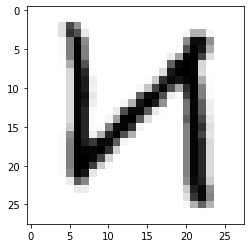

In [42]:
img = np.zeros((28,28))

# read emnist-letters train image from google drive

train_alpha_img = open('/content/drive/MyDrive/Learning_data/emnist-letters-train-images-idx3-ubyte', 'rb')
train_alpha_img.read(16)

X_alpha_train_list = []

while True:    
    s = train_alpha_img.read(784)             # 784바이트씩 읽음

    if not s:
        break;

    img = np.reshape(unpack(len(s)*'B',s), (28,28))
    X_alpha_train_list.append(img)            # 각 숫자영역별로 해당이미지를 추가

X_alpha_train = np.array(X_alpha_train_list)  # List to ndarray

# read emnist-letters test image from google drive

test_alpha_img = open('/content/drive/MyDrive/Learning_data/emnist-letters-test-images-idx3-ubyte', 'rb')
test_alpha_img.read(16)

X_alpha_test_list = []

while True:    
    s = test_alpha_img.read(784)              # 784바이트씩 읽음

    if not s:
        break;

    img = np.reshape(unpack(len(s)*'B',s), (28,28))
    X_alpha_test_list.append(img)            # 각 숫자영역별로 해당이미지를 추가

X_alpha_test = np.array(X_alpha_test_list)    # List to ndarray


# Show last one image

plt.imshow(img, cmap = cm.binary)             # binary형태의 이미지 설정
plt.show()

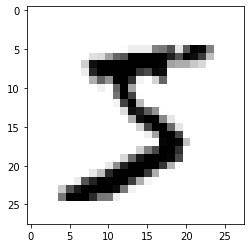

In [43]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
# Number image ndarray 
(X_number_train, y_number_train), (X_number_test, y_number_test) = mnist.load_data()

plt.imshow(X_number_train[0], cmap = cm.binary)             # binary형태의 이미지 설정
plt.show()

In [44]:
print(X_number_train.shape)
print(X_alpha_train.shape)

print(X_number_test.shape)
print(X_alpha_test.shape)

(60000, 28, 28)
(124800, 28, 28)
(10000, 28, 28)
(20800, 28, 28)


In [45]:
# class labels, 0 = number, 1 = alphabet
y_number_train = np.zeros(60000)
y_alpha_train = np.ones(124800)

y_number_test = np.zeros(10000)
y_alpha_test = np.ones(20800)

# Formatting the input data layer
Instead of a 28 x 28 matrix, we build our network to accept a 784-length vector.

Each image needs to be then reshaped (or flattened) into a vector. We'll also normalize the inputs to be in the range [0-1] rather than [0-255]. Normalizing inputs is generally recommended, so that any additional dimensions (for other network architectures) are of the same scale.

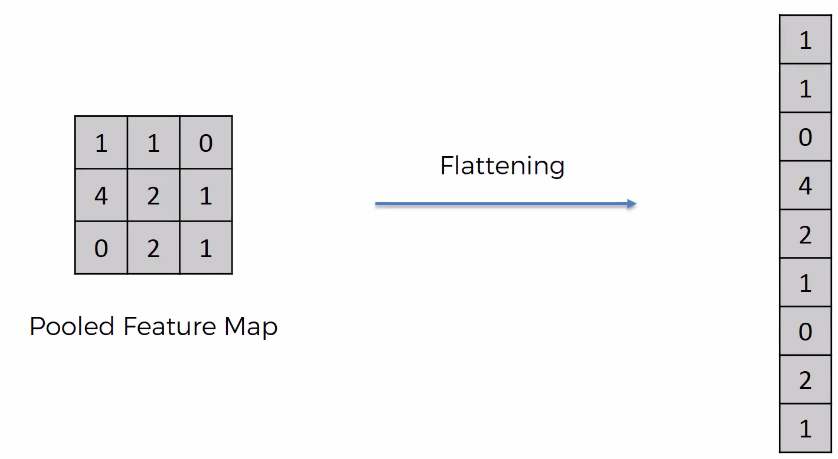

In [46]:
X_train = np.concatenate((X_number_train, X_alpha_train), axis=0) # concatenate number and alphabet image vectors
X_test = np.concatenate((X_number_test, X_alpha_test), axis=0)

X_train = X_train.reshape(184800, 784)  # reshape 184,800 28 x 28 matrices into 184,800 784-length vectors.
X_test = X_test.reshape(30800, 784)     # reshape 30,800 28 x 28 matrices into 30,800 784-length vectors.

X_train = X_train.astype('float32')     # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                          # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print(X_train.shape)
print(X_test.shape)

y_train = np.concatenate((y_number_train, y_alpha_train), axis=0)
y_test = np.concatenate((y_number_test, y_alpha_test), axis=0)

print(y_train.shape)
print(y_test.shape)

(184800, 784)
(30800, 784)
(184800,)
(30800,)


We then modify our classes (number or alphabet) to be in the one-hot format, i.e.

```
c -> [0, 1]
a -> [0 ,1]
2 -> [1, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0.06, 0.94]
```
then it is most probable that the image is that of the digit `1`.

In [47]:
nb_classes = 2    # number of classes

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# Building a 3-layer fully connected network (FCN)

We use only 2 input nodes

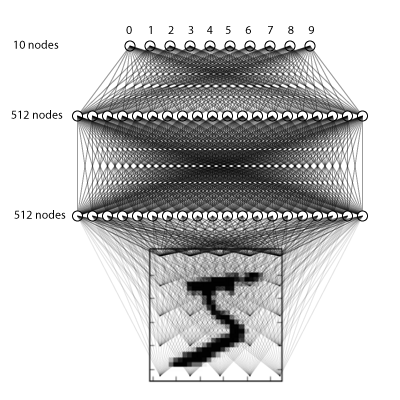

In [50]:
# The Sequential model is a linear stack of layers and is very common.

model = Sequential()

# The first hidden layer is a set of 512 nodes (artificial neurons).
# Each node will receive an element from each input vector and apply some weight and bias to it.

model.add(Dense(512, input_shape=(784,))) #(784,) is not a typo -- that represents a 784 length vector!

# An "activation" is a non-linear function applied to the output of the layer above.
# It checks the new value of the node, and decides whether that artifical neuron has fired.
# The Rectified Linear Unit (ReLU) converts all negative inputs to nodes in the next layer to be zero.
# Those inputs are then not considered to be fired.
# Positive values of a node are unchanged.

model.add(Activation('relu'))

# Dropout zeroes a selection of random outputs (i.e., disables their activation)
# Dropout helps protect the model from memorizing or "overfitting" the training data.
model.add(Dropout(0.2))

# The second hidden layer appears identical to our first layer.
# However, instead of each of the 512-node receiving 784-inputs from the input image data,
# they receive 512 inputs from the output of the first 512-node layer.

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

# The final layer of 10 neurons in fully-connected to the previous 512-node layer.
# The final layer of a FCN should be equal to the number of desired classes (10 in this case).
model.add(Dense(2))

# The "softmax" activation represents a probability distribution over K different possible outcomes.
# Its values are all non-negative and sum to 1.

model.add(Activation('softmax'))

In [51]:
# Summarize the built model

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               401920    
                                                                 
 activation_3 (Activation)   (None, 512)               0         
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                

# Compiling the model

In [53]:
# Let's use the Adam optimizer for learning
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model

In [54]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=5,
          verbose=1)

Epoch 1/5
1444/1444 [==============================] - 21s 13ms/step - loss: 0.0321 - accuracy: 0.9883
Epoch 2/5
1444/1444 [==============================] - 20s 14ms/step - loss: 0.0117 - accuracy: 0.9960
Epoch 3/5
1444/1444 [==============================] - 19s 13ms/step - loss: 0.0083 - accuracy: 0.9971
Epoch 4/5
1444/1444 [==============================] - 19s 13ms/step - loss: 0.0072 - accuracy: 0.9975
Epoch 5/5
1444/1444 [==============================] - 20s 14ms/step - loss: 0.0057 - accuracy: 0.9980


# Evaluate Model's Accuracy on Test Data

In [55]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

963/963 [==============================] - 3s 3ms/step - loss: 0.0060 - accuracy: 0.9980
Test score: 0.00597539683803916
Test accuracy: 0.9979545474052429


# Verify predictions

Ref: https://www.tensorflow.org/tutorials/keras/classification

In [57]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [58]:
predictions = probability_model.predict(X_test)

In [111]:
# predictions_array, array([[0.7310586 , 0.26894143],
#       [0.7310586 , 0.26894143],
#       [0.7310585 , 0.2689415 ],
#       ...,
#       [0.26894143, 0.7310586 ],
#       [0.26894143, 0.7310586 ],
#       [0.26894143, 0.7310586 ]], dtype=float32)
# true_label, numpy=array([0, 0, 0, ..., 1, 1, 1])

def plot_image(i, predictions_array, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label[i]:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format('number' if predicted_label == 0 else 'alphabet',
                                100*np.max(predictions_array),
                                'number' if true_label[i] == 0 else 'alphabet'),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(2))
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

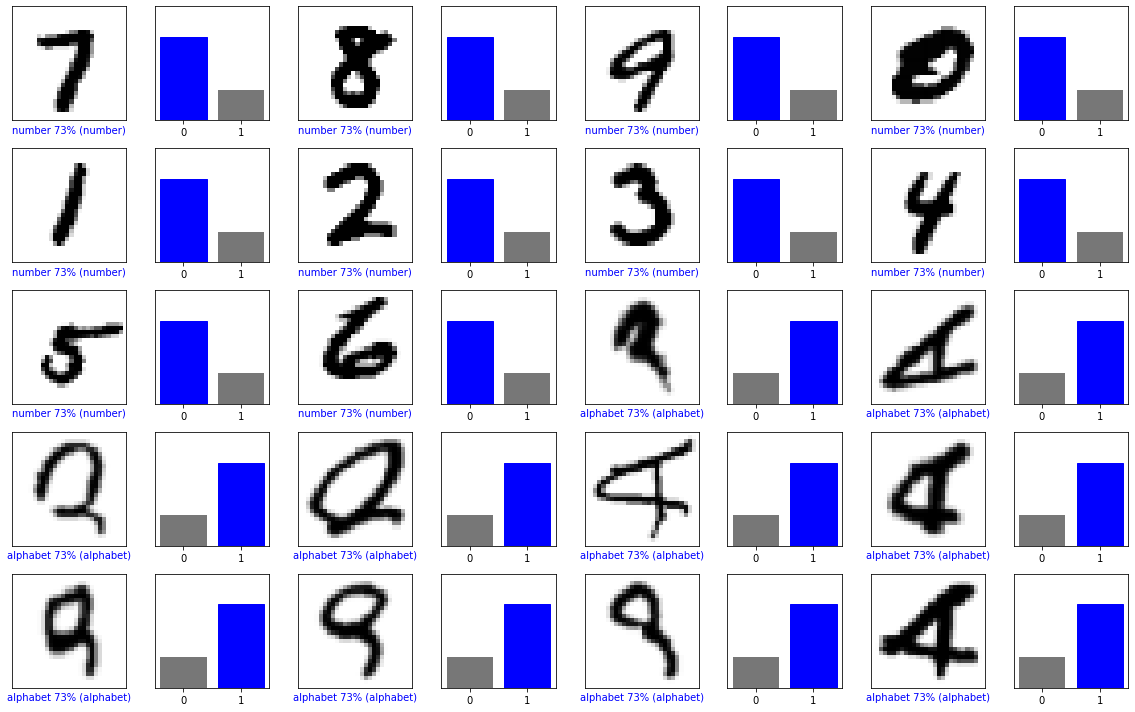

In [115]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  idx = i + 9990
  plot_image(idx, predictions[idx], Y_test.argmax(1), X_test[idx].reshape(28, 28))
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(idx, predictions[idx], Y_test.argmax(1))
plt.tight_layout()
plt.show()